In [5]:
import os
import sys
sys.path.append('../')

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib import cm
from torch_geometric.data import Data, DataLoader

from models.interaction_network import InteractionNetwork
from models.graph import Graph
from models.dataset import GraphDataset

In [19]:
plt.style.use('seaborn-paper')
colors = cm.Paired.colors
base = 'train_output'

#pt_map = {'0p5': 0.5, '0p6': 0.6, '0p7': 0.7, '0p8': 0.8, '0p9': 0.9, '1': 1,
#          '1p1': 1.1, '1p2': 1.2, '1p3': 1.3, '1p4': 1.4, '1p5': 1.5, '1p6': 1.6,
#          '1p7': 1.7, '1p8': 1.8, '1p9': 1.9, '2': 2}

train_output = os.listdir(base)
train_output = np.array([os.path.join(base, f) 
                         for f in train_output 
                         if ('.npy' in f and 
                             'hyper' not in f and
                             'hu' not in f and
                             'old' not in f and 
                             '20' not in f and 
                             '25' not in f)])
pt = np.array([float(f.split('_')[-2].split('GeV')[0]) for f in train_output])
train_output = train_output[np.argsort(-1*pt)]
pts = pt[np.argsort(-1*pt)]
pts=1.5

ValueError: could not convert string to float: '1p5'

In [17]:
pts=[2, 0.5]

IndexError: list index out of range

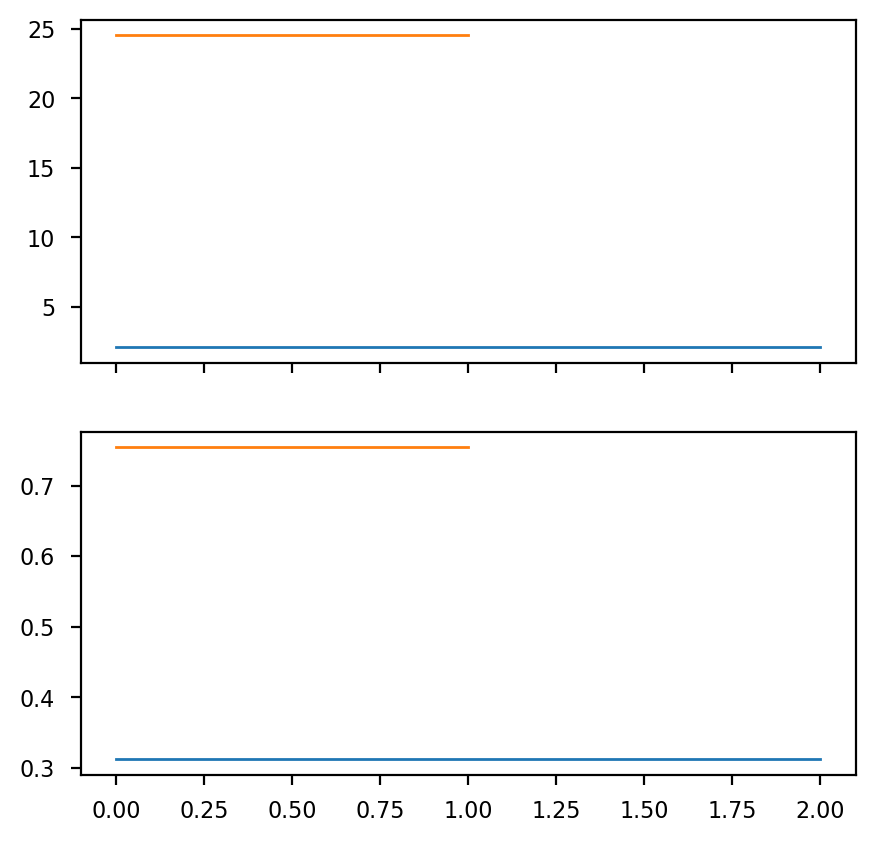

In [18]:


n_epoch = 250
colors = cm.Paired.colors

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,5), dpi=200, sharex=True)
for i,f in enumerate(train_output):
    out = np.load(f, allow_pickle=True).item()
    #print(moving_average(out['test_loss'][:m], 3))
    pt = pts[i]
    #if pt < 0.6 or pt > 1: continue
    epochs = np.arange(1, n_epoch+1, 1)
    m = len(out['test_loss']) if (len(out['test_loss']) < n_epoch) else n_epoch
    
    axs[0].plot(moving_average(out['test_loss'][:m], 3), markersize=5, 
                linewidth=1, zorder=i*5,
                linestyle='-', label=r'$p_T^{min}=$ '+str(pt))
    axs[1].plot(moving_average(out['test_acc'][:m], 3), markersize=5, 
                linewidth=1, zorder=i*5,
                linestyle='-', label=r'$p_T^{min}=$ '+str(pt))

    
handles, labels = axs[1].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), reverse=True, key=lambda t: t[0].split(' ')[1]))
fig.legend(handles, labels, bbox_to_anchor=(1.17, 0.67))

#axs[0].legend(loc='best')
#axs[0].set_ylim([0.001,0.007])
axs[0].set_ylabel('BCE Loss')
#axs[0].set_xlabel('Epoch')
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

#axs[1].set_ylim([0.9965,0.999])
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
#axs[1].set_yticks([0.9965,0.997,0.9975,0.998,0.9985,0.999])


#plt.savefig('paper_plots/training_convergence.pdf', format='PDF', bbox_inches='tight')
plt.tight_layout()
plt.show()



In [8]:
def load_graph(graph_path):
    with np.load(graph_path) as f:
        x = torch.from_numpy(f['x'])
        edge_attr = torch.from_numpy(f['edge_attr'])
        edge_index = torch.from_numpy(f['edge_index'])
        y = torch.from_numpy(f['y'])
        pid = torch.from_numpy(f['pid'])
        data = Data(x=x, edge_index=edge_index,
                    edge_attr=torch.transpose(edge_attr, 0, 1),
                    y=y, pid=pid)
        data.num_nodes = len(x)
    return data

In [20]:
def draw_graph_rz(X, idxs, y, out,                   
                  cut=0.5, savefig=False, filename='out.png'):
    
    cutoff = int(len(idxs[1])/2.)
    X = np.array(X)
    feats_o = X[idxs[0,:cutoff]]
    feats_i = X[idxs[1,:cutoff]]
    
    directed_disagreements = np.where(((out[:cutoff]>cut) & 
                                       (out[cutoff:]<cut)) | 
                                      ((out[:cutoff]<cut) & 
                                       (out[cutoff:]>cut)) == True)[0]
    print('Directed Disagreements:', len(directed_disagreements))
    
    y, out = y[:cutoff], np.min(np.stack((out[:cutoff], out[cutoff:])), axis=0) #(out[:cutoff]+out[cutoff:])/2.
    
    print('X.shape', X.shape,
          'idxs.shape', idxs.shape,
          'y.shape', y.shape,
          'out.shape', out.shape)
    
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(X[:,2], X[:,0], c='silver', lw=0, marker='s', s=8)
    
    TP = ((out>cut) & (y>0.5))
    print('Directed Disagreements (TP):', np.sum(TP[directed_disagreements]==True))
    TN = ((out<cut) & (y<0.5))
    print('Directed Disagreements (TN):', np.sum(TN[directed_disagreements]==True))
    FP = ((out>cut) & (y<0.5))
    FN = ((out<cut) & (y>0.5))
    wrong = (((out<cut) & (y>0.5)) | ((out>cut) & (y<0.5)))
    
    print('TP: {}'.format(np.sum(TP)))
    print('TN: {}'.format(np.sum(TN)))
    print('FP: {}'.format(np.sum(FP)))
    print('FN: {}'.format(np.sum(FN)))
    print('Wrong: {}/{}={:3f}'.format(np.sum(wrong), len(wrong), np.sum(wrong)/len(wrong)))
    print('Right: {}/{}={:3f}'.format(np.sum((TP|TN)), len(TP), np.sum((TP|TN))/len(TP)))
    print('TPR: {:.4f}'.format((np.sum(TP)/(np.sum(TP)+np.sum(FN)))))
    print('TNR: {:.4f}'.format(np.sum(TN)/(np.sum(TN)+np.sum(FP))))
    
    ax.plot((feats_o[TP][:,2], feats_i[TP][:,2]),
            (feats_o[TP][:,0], feats_i[TP][:,0]),
            'go-', lw=0.08, ms=0.0, alpha=0.3)
    ax.plot((feats_o[TN][:,2], feats_i[TN][:,2]),
            (feats_o[TN][:,0], feats_i[TN][:,0]),
            'ko-', lw=0.02, ms=0.0, alpha=0.1)
    ax.plot((feats_o[FP][:,2], feats_i[FP][:,2]),
            (feats_o[FP][:,0], feats_i[FP][:,0]),
            'ro-', lw=0.3, ms=0.0, alpha=0.3, zorder=10)
    ax.plot((feats_o[FN][:,2], feats_i[FN][:,2]),
            (feats_o[FN][:,0], feats_i[FN][:,0]),
            'yo-', lw=0.3, ms=0.0, alpha=0.3, zorder=10)

    green_patch = mpatches.Patch(color='green', label='True Positive')
    black_patch = mpatches.Patch(color='black', label='True Negative')
    red_patch = mpatches.Patch(color='red', label='False Positive')
    yellow_patch = mpatches.Patch(color='yellow', label='False Negative')
    ax.legend(handles=[green_patch, black_patch, red_patch, yellow_patch], loc='lower right')#bbox_to_anchor=[0.67, -0.2])
    ax.set_ylabel("r [m]")
    ax.set_xlabel("z [m]")
    #ax.set_xlim([-1.6, 1.6])
    #ax.set_xticks([-1.5, 1.5])
    #ax.set_yticks([0.02, 0.2])
    #ax.set_ylim([0, 0.2])
    if (savefig): plt.savefig(filename, format='PDF', bbox_inches='tight')
    plt.show()

In [21]:
import torch.nn.functional as F

graph = load_graph('output/PU200/2GeV/event100_g000.npz')

interaction_network = InteractionNetwork(40)
model='trained_models/train1_PyG_heptrkx_classic_epoch4_2GeV_redo.pt'
interaction_network.load_state_dict(torch.load(model))
interaction_network.eval()

x, edge_attr, edge_index = graph.x, torch.transpose(graph.edge_attr, 0, 1), graph.edge_index
y, pid = graph.y, graph.pid
row, col = edge_index
row, col = torch.cat([row, col], dim=0), torch.cat([col, row], dim=0)
edge_index = torch.stack([row, col], dim=0)
edge_attr = torch.cat([edge_attr, -1*edge_attr], dim=1)
y = torch.cat([y,y])

print(x.shape, edge_attr.shape, edge_index.shape, y.shape, pid.shape)
data = Data(x=x, edge_index=edge_index,
            edge_attr=torch.transpose(edge_attr, 0, 1),
            y=y, pid=pid)
data.num_nodes = len(x)


output = interaction_network(data)
loss = F.binary_cross_entropy(output.detach().squeeze(1), data.y)

print(loss.item())
draw_graph_rz(x.detach().numpy(), edge_index.detach().numpy(), y.detach().numpy(), 
              output.detach().numpy().squeeze(1), cut=0.05049, savefig=False)
              #filename='paper_plots/confusion_matrix_graph.pdf')


torch.Size([2273, 3]) torch.Size([4, 20218]) torch.Size([2, 20218]) torch.Size([20218]) torch.Size([2273])


RuntimeError: expected scalar type Float but found Double

In [36]:
(566+153)/(566+153+240)

0.7497393117831074

In [41]:
import os
import sys
sys.path.append('../')

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib import cm
from torch_geometric.data import Data, DataLoader

from models.interaction_network import InteractionNetwork
from models.graph import Graph
from models.dataset import GraphDataset

In [24]:
def plot_rz(X, idxs, y, save_fig=False, filename="rz.png"):
    X = np.array(X)
    feats_o = X[idxs[0,:]]
    feats_i = X[idxs[1,:]]
    
    fig = plt.figure(dpi=1000)
    for i in range(len(X)):        
        plt.scatter(X[i][2], X[i][0], c='silver', linewidths=0, marker='s', s=8)

    track_segs_o = feats_o[y>0.5]
    track_segs_i = feats_i[y>0.5]
    for i in range(len(track_segs_o)):
        plt.plot((track_segs_o[i][2], track_segs_i[i][2]),
                 (track_segs_o[i][0], track_segs_i[i][0]),
                  marker='o', ls='-', color='blue', lw=0.25, ms=0.1, alpha=1)

    false_edges_o = feats_o[y<0.5]
    false_edges_i = feats_i[y<0.5]
    for i in range(len(false_edges_o)):
        plt.plot((false_edges_o[i][2], false_edges_i[i][2]),
                 (false_edges_o[i][0], false_edges_i[i][0]),
                  marker='o', ls='-', color='black', lw=0.25, ms=0.1, alpha=0.5)
        
    plt.ylabel("r [m]")
    plt.xlabel("z [m]")
    #plt.legend()
    if (save_fig): plt.savefig(filename, dpi=1200)
    plt.show()

In [25]:
def load_graph(graph_path):
    with np.load(graph_path) as f:
        x = torch.from_numpy(f['x'])
        edge_attr = torch.from_numpy(f['edge_attr'])
        edge_index = torch.from_numpy(f['edge_index'])
        y = torch.from_numpy(f['y'])
        pid = torch.from_numpy(f['pid'])
        data = Data(x=x, edge_index=edge_index,
                    edge_attr=torch.transpose(edge_attr, 0, 1),
                    y=y, pid=pid)
        data.num_nodes = len(x)
    return data

In [26]:
graph = load_graph('output/PU200/2GeV/event619_g000.npz')


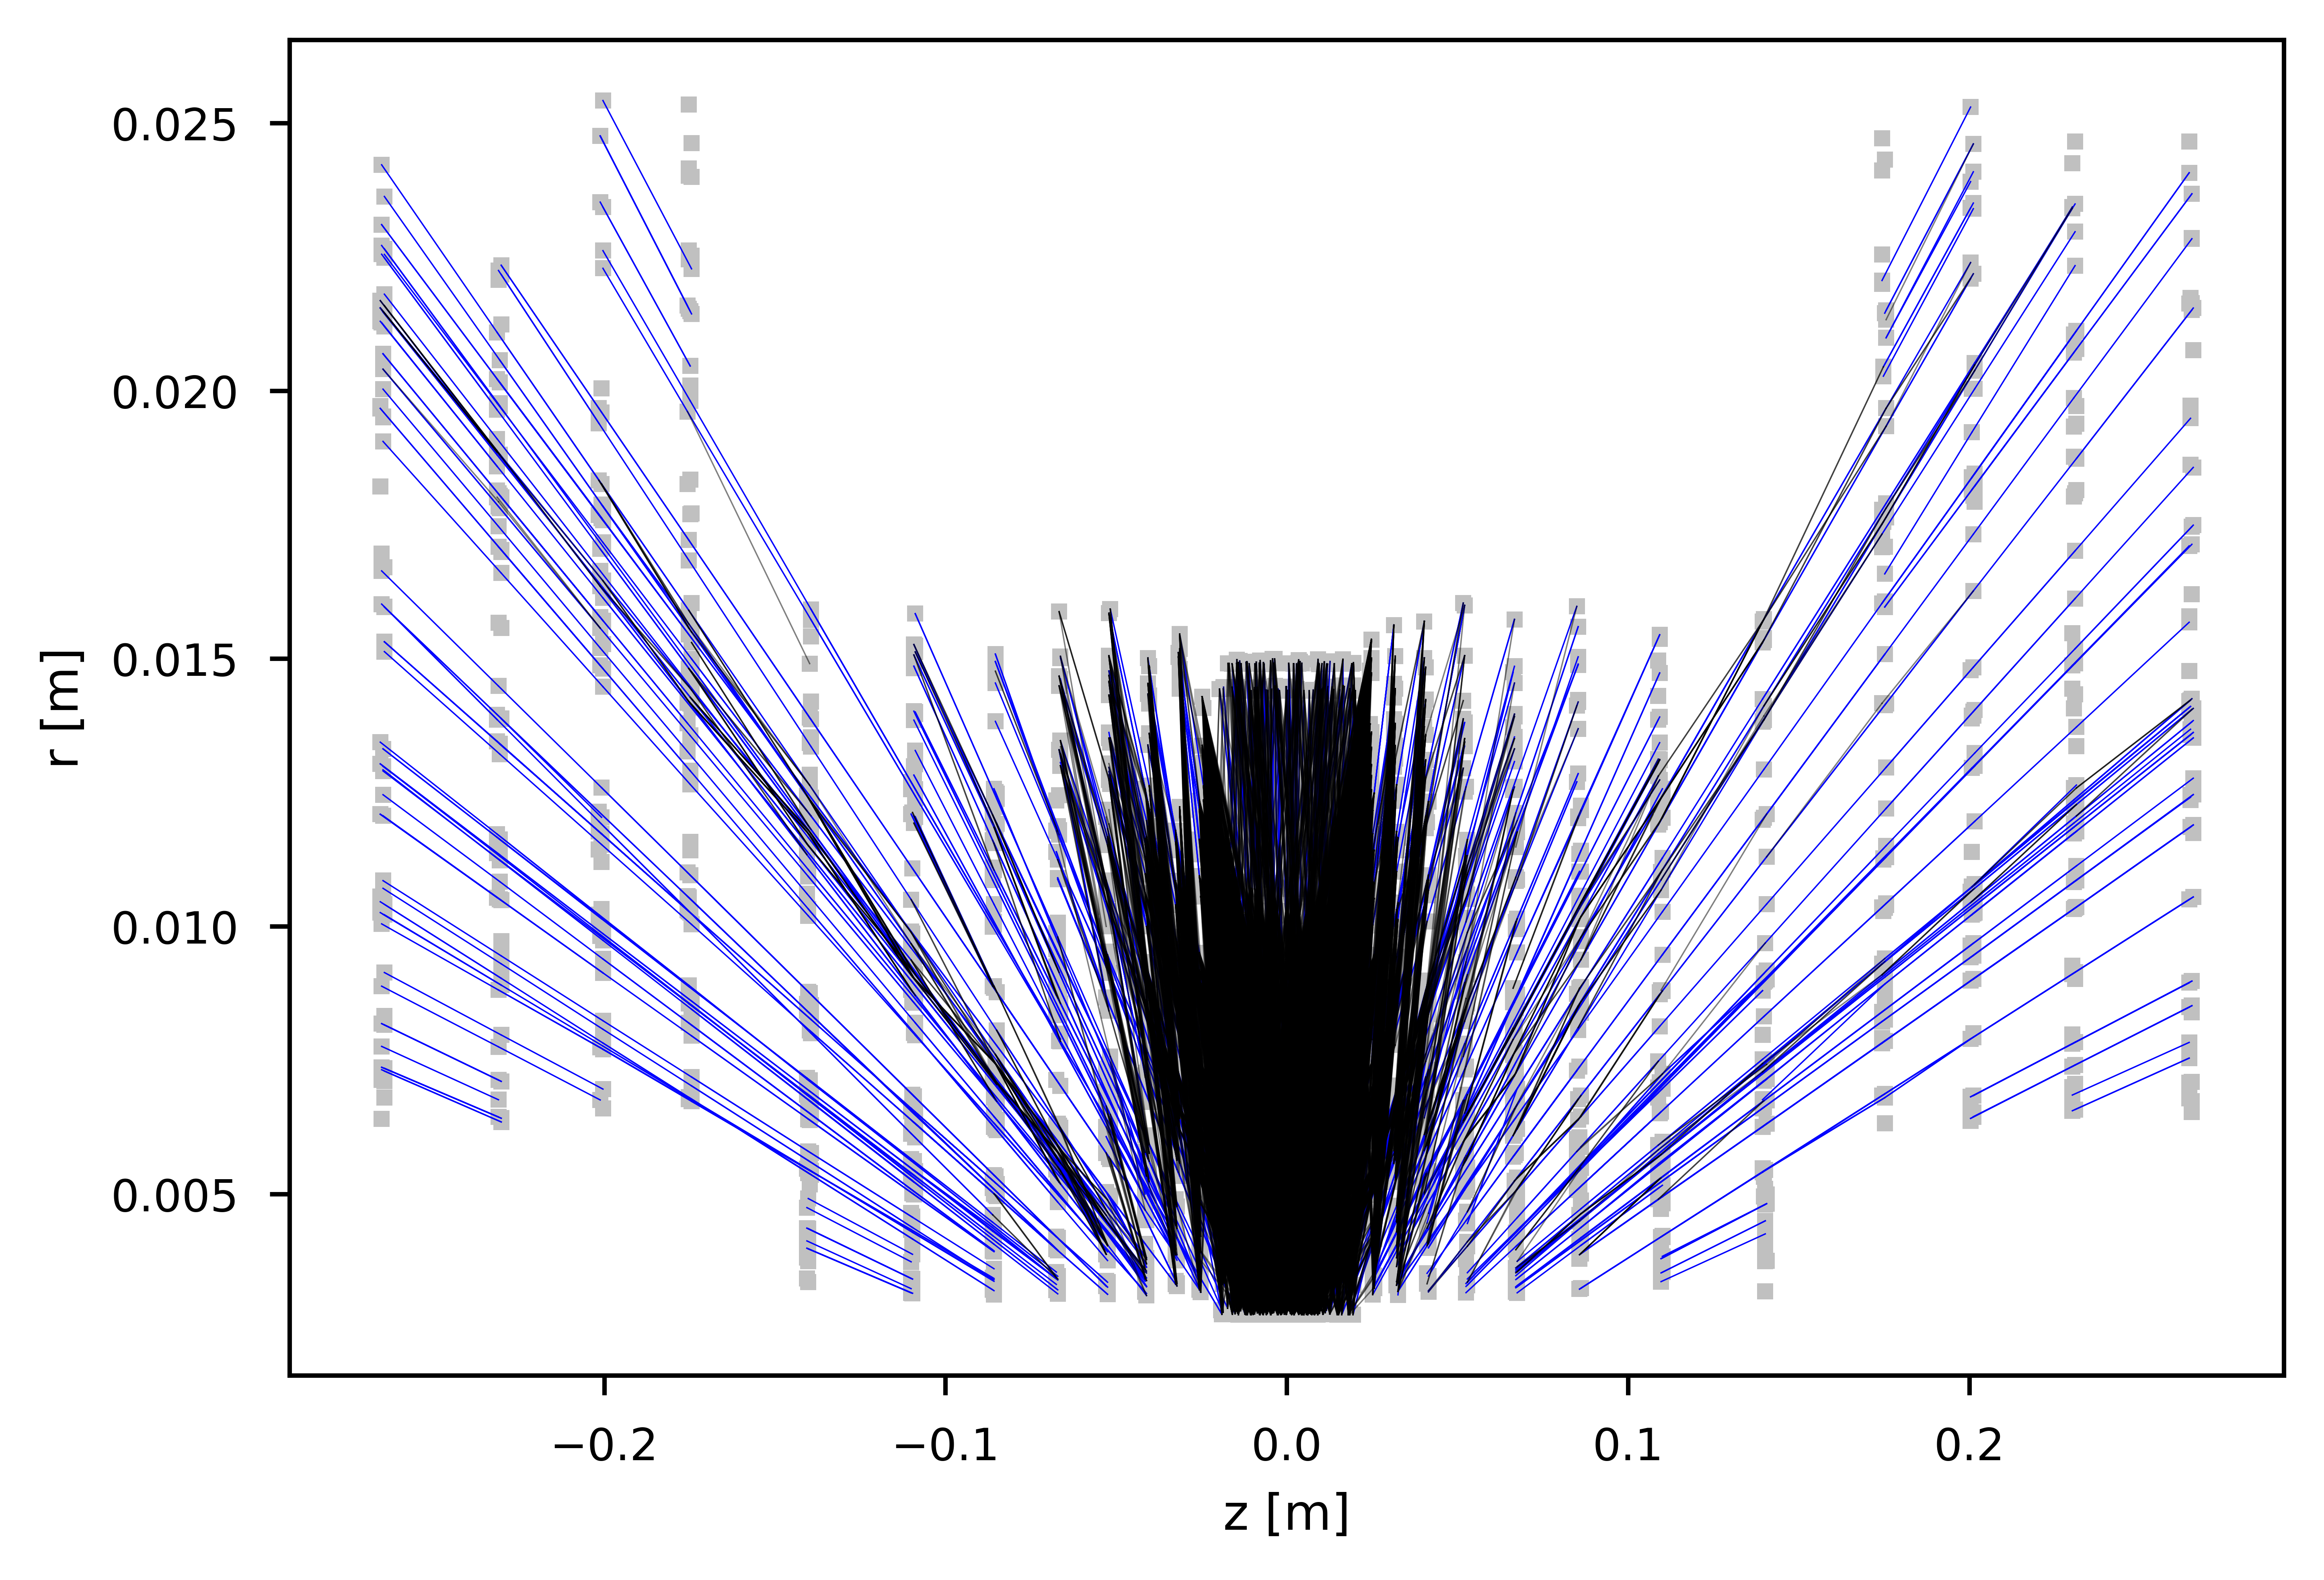

In [27]:
plot_rz(graph.x, graph.edge_index, graph.y)

In [46]:
def efficiency(graph): 
    y_list = graph.y.tolist()
    efficiency = np.sum(y_list)/len(y_list)
    return efficiency

In [47]:
energies = ['2GeV']
mean_efficiencies = []
for energy in energies: 
    efficiencies = []
    for filename in os.listdir("output/fixed/"+energy):
        graph = load_graph("output/fixed/" + energy +"/"+filename)
        efficiencies.append(efficiency(graph))
    mean_efficiencies.append(np.mean(efficiencies))
    


In [48]:
mean_efficiencies

[0.5163418454082869]

<AxesSubplot:xlabel='axis0'>

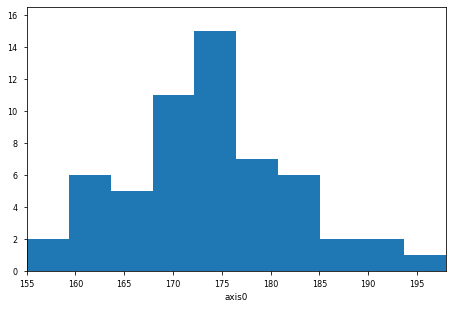

In [36]:
from physt import h1

# Create the sample
heights = [160, 155, 156, 198, 177, 168, 191, 183, 184, 179, 178, 172, 173, 175,
           172, 177, 176, 175, 174, 173, 174, 175, 177, 169, 168, 164, 175, 188,
           178, 174, 173, 181, 185, 166, 162, 163, 171, 165, 180, 189, 166, 163,
           172, 173, 174, 183, 184, 161, 162, 168, 169, 174, 176, 170, 169, 165]

hist = h1(heights, 10)           # <--- get the histogram data
hist << 190                      # <--- add a forgotten value
hist.plot()                      # <--- and plot it